# Test - FUZEO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Chargement des données 

In [2]:
# Chargez les 4 feuilles (ventes, clients, produits, budget) 

def read_excel_file(file_path: str, sheet_name: str) -> pd.DataFrame:
    """
    Lit un fichier Excel et retourne son contenu sous forme de DataFrame.

    :param file_path: Chemin vers le fichier Excel.
    :param sheet_name: Nom de la feuille à lire.
    :return: DataFrame contenant les données de la feuille Excel.
    """
    try:
        df = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name)
        return df
    except Exception as e:
        print(f"Error reading the Excel file: {e}")
        raise e


path = r"C:\Users\sebas\Desktop\Test FUZEO\FUZEO_dataset_evaluation_pbi 1.xlsx"

keys = ['Sales Orders', 'Customers', 'Products', 'Budgets', 'Regions',
            'Monthly Weightings']
data = {}

for sheet_name in keys:
    print(f"Reading sheet: {sheet_name}")
    df = read_excel_file(path, sheet_name)
    data[sheet_name] = df
    print(f"Data from sheet: {len(df)} rows") 



Reading sheet: Sales Orders
Data from sheet: 7991 rows
Reading sheet: Customers
Data from sheet: 53 rows
Reading sheet: Products
Data from sheet: 14 rows
Reading sheet: Budgets
Data from sheet: 36 rows
Reading sheet: Regions
Data from sheet: 100 rows
Reading sheet: Monthly Weightings
Data from sheet: 12 rows


In [3]:
# Réalisez les jointures nécessaires. 

joined_sales_customers = pd.merge(
        data['Sales Orders'],
        data['Customers'],
        how='left',
        left_on='Customer Name Index',
        right_on='Customer Index'
)

joined_sales_customers_products = pd.merge(
        joined_sales_customers,
        data['Products'],
        how='left',
        left_on='Product Description Index',
        right_on='Index'
)

joined_regions_budgets = pd.merge(
        data['Budgets'],
        data['Regions'],
        how='left',
        on='City'
)[['Index'] + data['Budgets'].columns.to_list()]

final_data = pd.merge(
        joined_sales_customers_products,
        joined_regions_budgets,
        how='left',
        left_on='Delivery Region Index',
        right_on='Index'
)

In [4]:
# Je vérifie les 1ères lignes
print(joined_sales_customers_products.head())
print(joined_regions_budgets.head())

   OrderNumber  OrderDate  Ship Date  Customer Name Index      Channel  \
0  SO - 000101 2019-08-14 2019-10-15                   15  Distributor   
1  SO - 000102 2019-08-14 2019-10-23                   20    Wholesale   
2  SO - 000103 2019-08-14 2019-09-20                   16       Export   
3  SO - 000104 2019-08-14 2019-09-24                   48       Export   
4  SO - 000105 2019-08-14 2019-11-10                   49    Wholesale   

  Currency Code Warehouse Code  Delivery Region Index  \
0           USD         NXH382                     47   
1           NZD         GUT930                     36   
2           USD         GUT930                     39   
3           USD         AXW291                     20   
4           USD         AXW291                     20   

   Product Description Index  Order Quantity  Unit Price  Total Unit Cost  \
0                         11               5      1963.1         1001.181   
1                          2               5      3939.6  

### 2. Total des ventes et marge par région 

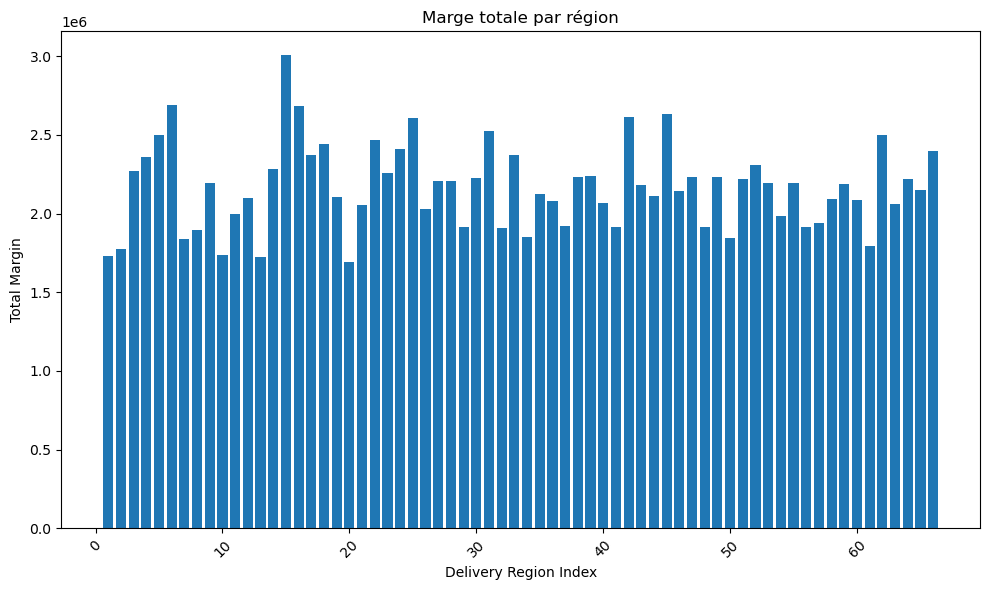

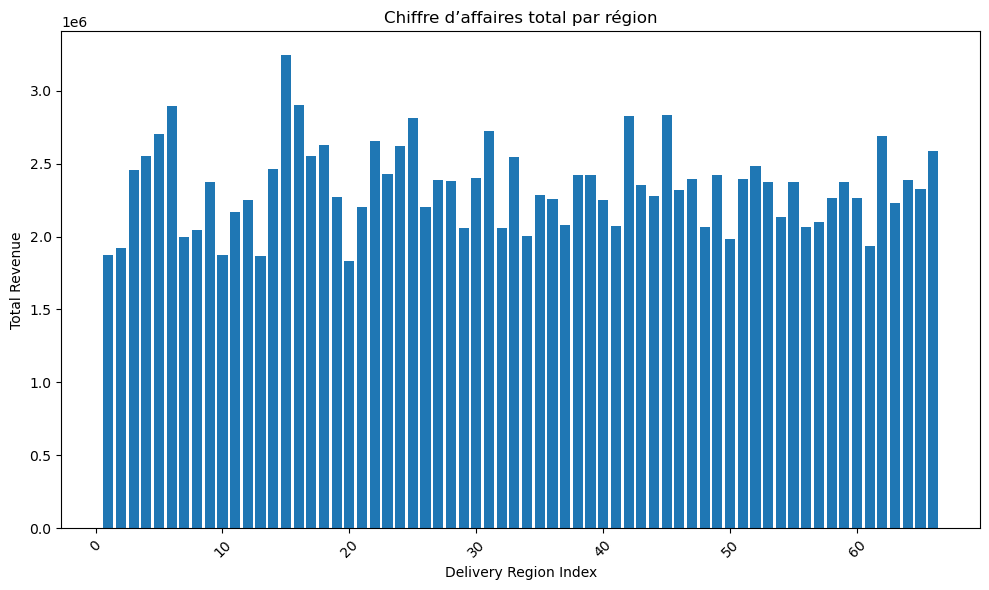

In [9]:
# Effectuez une jointure ventes ↔ clients, puis groupez par region.

def depict_chart(df, x: str, y: str, title: str = ''):
    """
    Affiche un graphique simple en barres.

    :param df: DataFrame contenant les données à visualiser.
    :param x: Nom de la colonne pour l'axe des x.
    :param y: Nom de la colonne pour l'axe des y.
    :param title: Titre du graphique.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.bar(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Agréger les ventes et coûts par région
group_by_region = (
    joined_sales_customers
    .groupby('Delivery Region Index')[['Total Revenue', 'Total Unit Cost']]
    .sum()
    .reset_index()
)

# Calcul de la marge
group_by_region['Total Margin'] = group_by_region['Total Revenue'] - group_by_region['Total Unit Cost']

# Affichage : Marge
depict_chart(group_by_region, 'Delivery Region Index', 'Total Margin', title='Marge totale par région')

# Affichage : Ventes
depict_chart(group_by_region, 'Delivery Region Index', 'Total Revenue', title='Chiffre d’affaires total par région')


### 3. Top 5 clients en chiffre d’affaires

In [13]:
# Groupez les ventes par nom_client et affichez les 5 premiers en montant.

top_customers = (
        final_data.groupby('Customer Names')['Total Revenue']
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .reset_index()
    )

print("Top 5 clients")
print(top_customers)

Top 5 clients
  Customer Names  Total Revenue
0       Medline       4081485.9
1     Pure Group      3821592.9
2        OUR Ltd      3676035.4
3  Eminence Corp      3643426.5
4  Apotheca, Ltd      3608492.7


### 4. Analyse temporelle 2023 

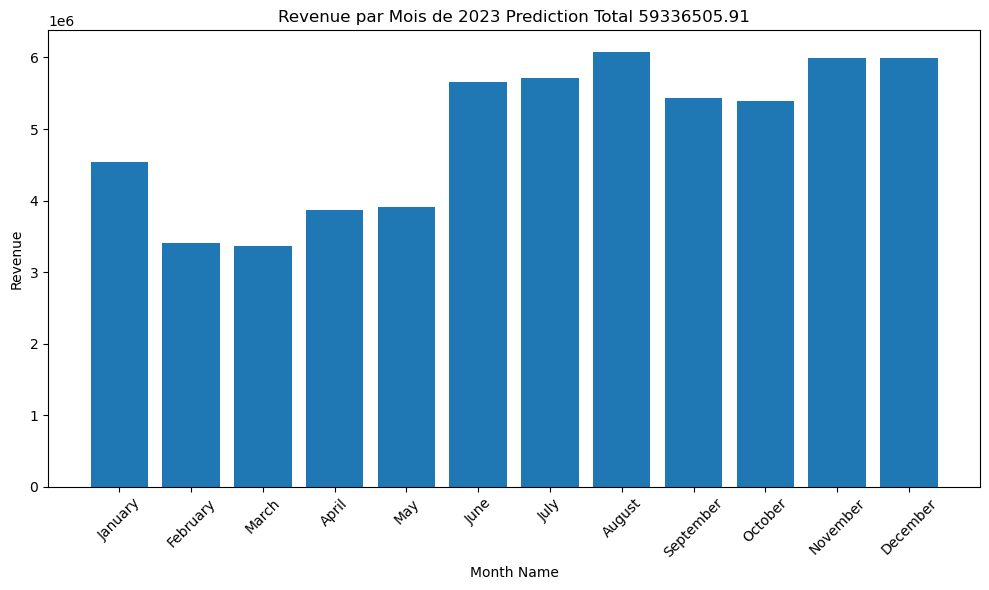

In [10]:
# Filtrez les ventes de 2023, puis affichez un graphe du CA par mois. 

# J'ai utilisé le taux de croissance annuel composé (CAGR) ou le taux de croissance simple pour estimer le chiffre d'affaires de 2023. 

weightings = data['Monthly Weightings']
final_data.loc[:, 'year'] = final_data.loc[:, 'OrderDate'].dt.year

result = final_data.groupby('year')['Total Revenue'].sum()

# Les données de 2022 et 2019 ne sont pas utilisées, car elles sont incomplètes dans le jeu de données

growth_rate = (result[2021] / result[2020]) - 1
revenue_2022 = result[2021] * (1 + growth_rate)
revenue_2023 = revenue_2022 * (1 + growth_rate)

prediction_2023 = weightings['Month Name'].reset_index()
prediction_2023.loc[:, 'Revenue'] = weightings['Monthly Weighting'] * revenue_2023

depict_chart(prediction_2023, x='Month Name', y='Revenue', title=f'Revenue par Mois de 2023 Prediction Total {prediction_2023["Revenue"].sum():.2f}')

### 5. Analyse budget vs réalisé 2020 

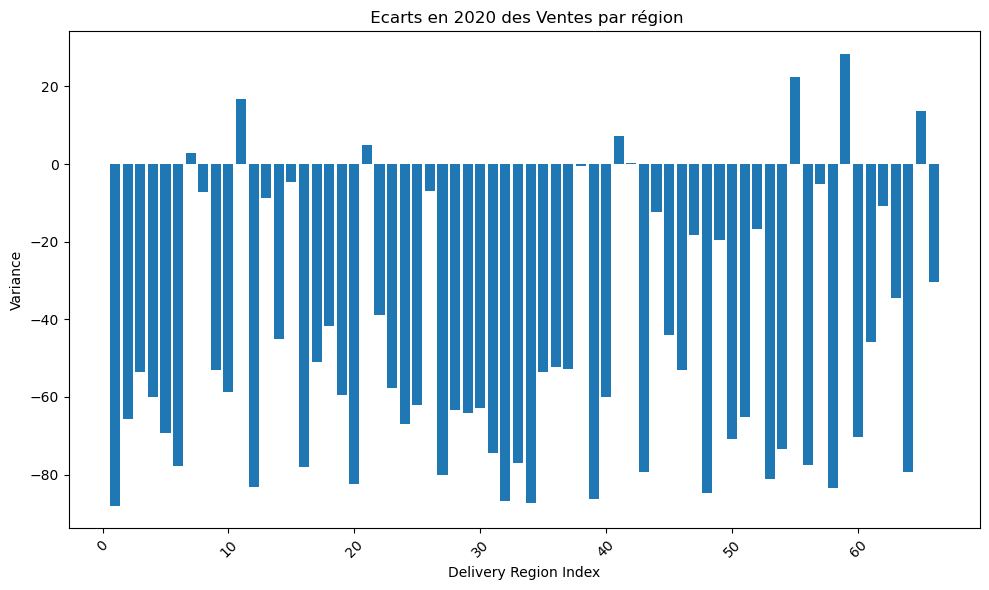

In [15]:
# Agrégez les ventes par région pour 2020, joignez au budget 2020 et calculez les écarts (€ et %).
# Visualisez-les. 


sales_2020 = final_data[final_data['OrderDate'].dt.year == 2020]
grouped_by_region = sales_2020.groupby('Delivery Region Index')['Total Revenue'].sum().reset_index()

result_df_2020 = pd.merge(
    grouped_by_region,
    joined_regions_budgets[joined_regions_budgets['Year'] == 2020],
    how='left',
    left_on='Delivery Region Index',
    right_on='Index'
)
result_df_2020['Variance'] = ((result_df_2020['Total Revenue'] - result_df_2020['Sales Budgets']) / result_df_2020['Sales Budgets']) * 100
result_df_2020['Variance'] = result_df_2020['Variance'].round(2)
depict_chart(result_df_2020, x='Delivery Region Index', y='Variance', title=" Ecarts en 2020 des Ventes par région",)

